# Examining circuit statistics

What kind of features are most predictive of mutational stability?

In [1]:
# %%
%load_ext autoreload
%autoreload 2

# %%
import numpy as np
import os
import corner
import sys
from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.express as px


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


from src.srv.sequence_exploration.sequence_analysis import b_tabulate_mutation_info
from src.utils.data.data_format_tools.common import load_json_as_dict
from src.utils.common.setup_new import prepare_config
from src.utils.circuit.agnostic_circuits.circuit_manager_new import CircuitModeller
from src.utils.evolution.evolver import Evolver
from src.utils.misc.numerical import count_monotonic_group_lengths, find_monotonic_group_idxs, is_within_range
from src.utils.misc.string_handling import string_to_tuple_list
from src.utils.misc.type_handling import flatten_listlike, get_first_elements
from src.utils.results.analytics.naming import get_analytics_types_all, get_true_names_analytics, get_true_interaction_cols
from tests_local.shared import create_test_inputs, CONFIG, TEST_CONFIG, five_circuits, mutate, simulate

# config = load_json_as_dict('../tests_local/configs/simple_circuit.json')
SEQ_LENGTH = 20
config = deepcopy(CONFIG)

In [2]:
# %%
# fn = '../data/ensemble_mutation_effect_analysis/2023_04_05_223653/summarise_simulation/tabulated_mutation_info.csv'
# fn = '../data/ensemble_mutation_effect_analysis/2023_04_11_192013/summarise_simulation/tabulated_mutation_info.csv'
fn = '../data/ensemble_mutation_effect_analysis/2023_05_09_220322/summarise_simulation/tabulated_mutation_info.csv'
info = pd.read_csv(fn)

# %%
# circuits, config, result_writer, info = create_test_inputs(deepcopy(CONFIG))

# circuits, config, data_writer = five_circuits(config, data_writer=None)

# %%

# circuits, config, data_writer = mutate(circuits, config, data_writer)

# %%

# circuits, config, data_writer = simulate(circuits, config, data_writer)

# %%


# info = b_tabulate_mutation_info(data_writer.ensemble_write_dir,
#                                 data_writer=data_writer, experiment_config=config)

# %%
# circuits = [Evolver(data_writer=result_writer,
#                     sequence_type=config.get('system_type')).mutate(
#             c,
#             write_to_subsystem=True,
#             algorithm=config.get('mutations', {}).get('algorithm', 'random')) for c in circuits]
# circuit_modeller = CircuitModeller(result_writer=result_writer, config=config)
# circuits = circuit_modeller.batch_circuits(
#     circuits=circuits,
#     methods={
#         "compute_interactions": {},
#         "init_circuits": {'batch': True},
#         'simulate_signal_batch': {'ref_circuit': None,
#                                   'batch': config['simulation']['use_batch_mutations']},
#         'write_results': {'no_visualisations': False, # config['experiment']['no_visualisations'],
#                           'no_numerical': False} #config['experiment']['no_numerical']}
#     }
# )


## Process summary

In [3]:

# %%
info['sp_distance'] = 0 
info.loc[(info['sensitivity_wrt_species-6'] <= 1) & (info['precision_wrt_species-6'] <= 10), 'sp_distance'] = np.sqrt(
    np.power(1-info['sensitivity_wrt_species-6'], 2) + np.power(10 - info['precision_wrt_species-6'], 2))
info.loc[(info['sensitivity_wrt_species-6'] <= 1) & (info['precision_wrt_species-6'] > 10), 'sp_distance'] = np.absolute(info['sensitivity_wrt_species-6'] - 1)
info.loc[(info['sensitivity_wrt_species-6'] > 1) & (info['precision_wrt_species-6'] <= 10), 'sp_distance'] = np.absolute(info['precision_wrt_species-6'] - 10)


Binding sites:

In [4]:

# %%
num_group_cols = [e.replace('energies', 'binding_sites_groups') for e in get_true_interaction_cols(info, 'energies')]
num_bs_cols = [e.replace('energies', 'binding_sites_count') for e in get_true_interaction_cols(info, 'energies')]
bs_idxs_cols = [e.replace('energies', 'binding_sites_idxs') for e in get_true_interaction_cols(info, 'energies')]
bs_range_cols = [e.replace('energies', 'binding_site_group_range') for e in get_true_interaction_cols(info, 'energies')]


# %%
for b, g, bs, bsi, r in zip(get_true_interaction_cols(info, 'binding_sites'), num_group_cols, num_bs_cols, bs_idxs_cols, bs_range_cols):
    fbs = [string_to_tuple_list(bb) for bb in info[b]]
    first = get_first_elements(fbs, empty_replacement=[])
    info[bs] = [count_monotonic_group_lengths(bb) for bb in first]
    info[bsi] = [find_monotonic_group_idxs(bb) for bb in first]
    info[g] = info[bs].apply(len)
    info[r] = [[(bb[0], bb[-1]) for bb in b] for b in info[bsi]]

Melt energies:


In [5]:

# %%
good_cols = list(info.columns)
[good_cols.remove(x) for x in get_true_interaction_cols(info, 'binding_rates_dissociation') + get_true_interaction_cols(info, 'eqconstants') +
 get_true_interaction_cols(info, 'energies') + get_true_interaction_cols(info, 'binding_sites') + num_group_cols + num_bs_cols]
good_cols


# %%
binding_idx_map = {e.replace('energies_', ''): i for i, e in enumerate(get_true_interaction_cols(info, 'energies'))}

# %%
infom = info.melt(good_cols, value_vars=get_true_interaction_cols(info, 'energies'), var_name='energies_idx', value_name='energies')
dfm = info.melt(good_cols, value_vars=num_group_cols, var_name='num_groups_idx', value_name='num_groups')
infom['idx_species_binding'] = dfm['num_groups_idx'].apply(lambda x: binding_idx_map[x.replace('binding_sites_groups_', '')])
infom['num_groups'] = dfm['num_groups']
dfm = info.melt(good_cols, value_vars=num_bs_cols, var_name='num_bs_idx', value_name='num_bs')
infom['num_bs'] = dfm['num_bs']

for k in ['binding_sites', 'binding_rates_dissociation', 'eqconstants']:
    dfm = info.melt(good_cols, value_vars=get_true_interaction_cols(info, k), var_name=f'{k}_idx', value_name=k)
    infom[k] = dfm[k]


# %% [markdown]
# Energy diffs:

# %%
for k in ['binding_rates_dissociation', 'eqconstants', 'energies']:
    infom[f'{k}_diffs'] = info.groupby(['circuit_name'])[get_true_interaction_cols(info, f'{k}')].apply(lambda x: x - x.iloc[0]).melt(value_vars=get_true_interaction_cols(info, f'{k}'), var_name='idx', value_name=f'{k}_diffs')[f'{k}_diffs']


/tmp/ipykernel_2500774/1272338202.py:29: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  infom[f'{k}_diffs'] = info.groupby(['circuit_name'])[get_true_interaction_cols(info, f'{k}')].apply(lambda x: x - x.iloc[0]).melt(value_vars=get_true_interaction_cols(info, f'{k}'), var_name='idx', value_name=f'{k}_diffs')[f'{k}_diffs']
/tmp/ipykernel_2500774/1272338202.py:29: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., gro

## Preliminary visualisations

In [6]:

# %%
relevant_cols = [
    'fold_change', 
    # 'initial_steady_states', 
    # 'max_amount', 'min_amount',
    'overshoot', 
    'RMSE', 
    'steady_states', 
    # 'response_time_wrt_species-6',
    # 'response_time_wrt_species-6_diff_to_base_circuit',
    # 'response_time_wrt_species-6_ratio_from_mutation_to_base',
    'precision_wrt_species-6',
    'precision_wrt_species-6_diff_to_base_circuit',
    'precision_wrt_species-6_ratio_from_mutation_to_base',
    'sensitivity_wrt_species-6',
    'sensitivity_wrt_species-6_diff_to_base_circuit',
    'sensitivity_wrt_species-6_ratio_from_mutation_to_base',
    'fold_change_diff_to_base_circuit',
    # 'initial_steady_states_diff_to_base_circuit',
    # 'max_amount_diff_to_base_circuit', 'min_amount_diff_to_base_circuit',
    'overshoot_diff_to_base_circuit', 
    # 'RMSE_diff_to_base_circuit',
    'steady_states_diff_to_base_circuit',
    'fold_change_ratio_from_mutation_to_base',
    # 'initial_steady_states_ratio_from_mutation_to_base',
    # 'max_amount_ratio_from_mutation_to_base',
    # 'min_amount_ratio_from_mutation_to_base',
    # 'overshoot_ratio_from_mutation_to_base',
    # 'RMSE_ratio_from_mutation_to_base',
    'steady_states_ratio_from_mutation_to_base', 
    # 'num_groups',
    'energies', 
    'binding_rates_dissociation',
    'eqconstants',
    'energies_diffs', 
    'binding_rates_dissociation_diffs',
    'eqconstants_diffs'
    ]

core.py:hist2d():593: Too few points to create valid contours WARNING
core.py:hist2d():593: Too few points to create valid contours WARNING
core.py:hist2d():593: Too few points to create valid contours WARNING
core.py:hist2d():593: Too few points to create valid contours WARNING
core.py:hist2d():593: Too few points to create valid contours WARNING
core.py:hist2d():593: Too few points to create valid contours WARNING
core.py:hist2d():593: Too few points to create valid contours WARNING
core.py:hist2d():593: Too few points to create valid contours WARNING
core.py:hist2d():593: Too few points to create valid contours WARNING
core.py:hist2d():593: Too few points to create valid contours WARNING
core.py:hist2d():593: Too few points to create valid contours WARNING
core.py:hist2d():593: Too few points to create valid contours WARNING
core.py:hist2d():593: Too few points to create valid contours WARNING
core.py:hist2d():593: Too few points to create valid contours WARNING
core.py:hist2d():593

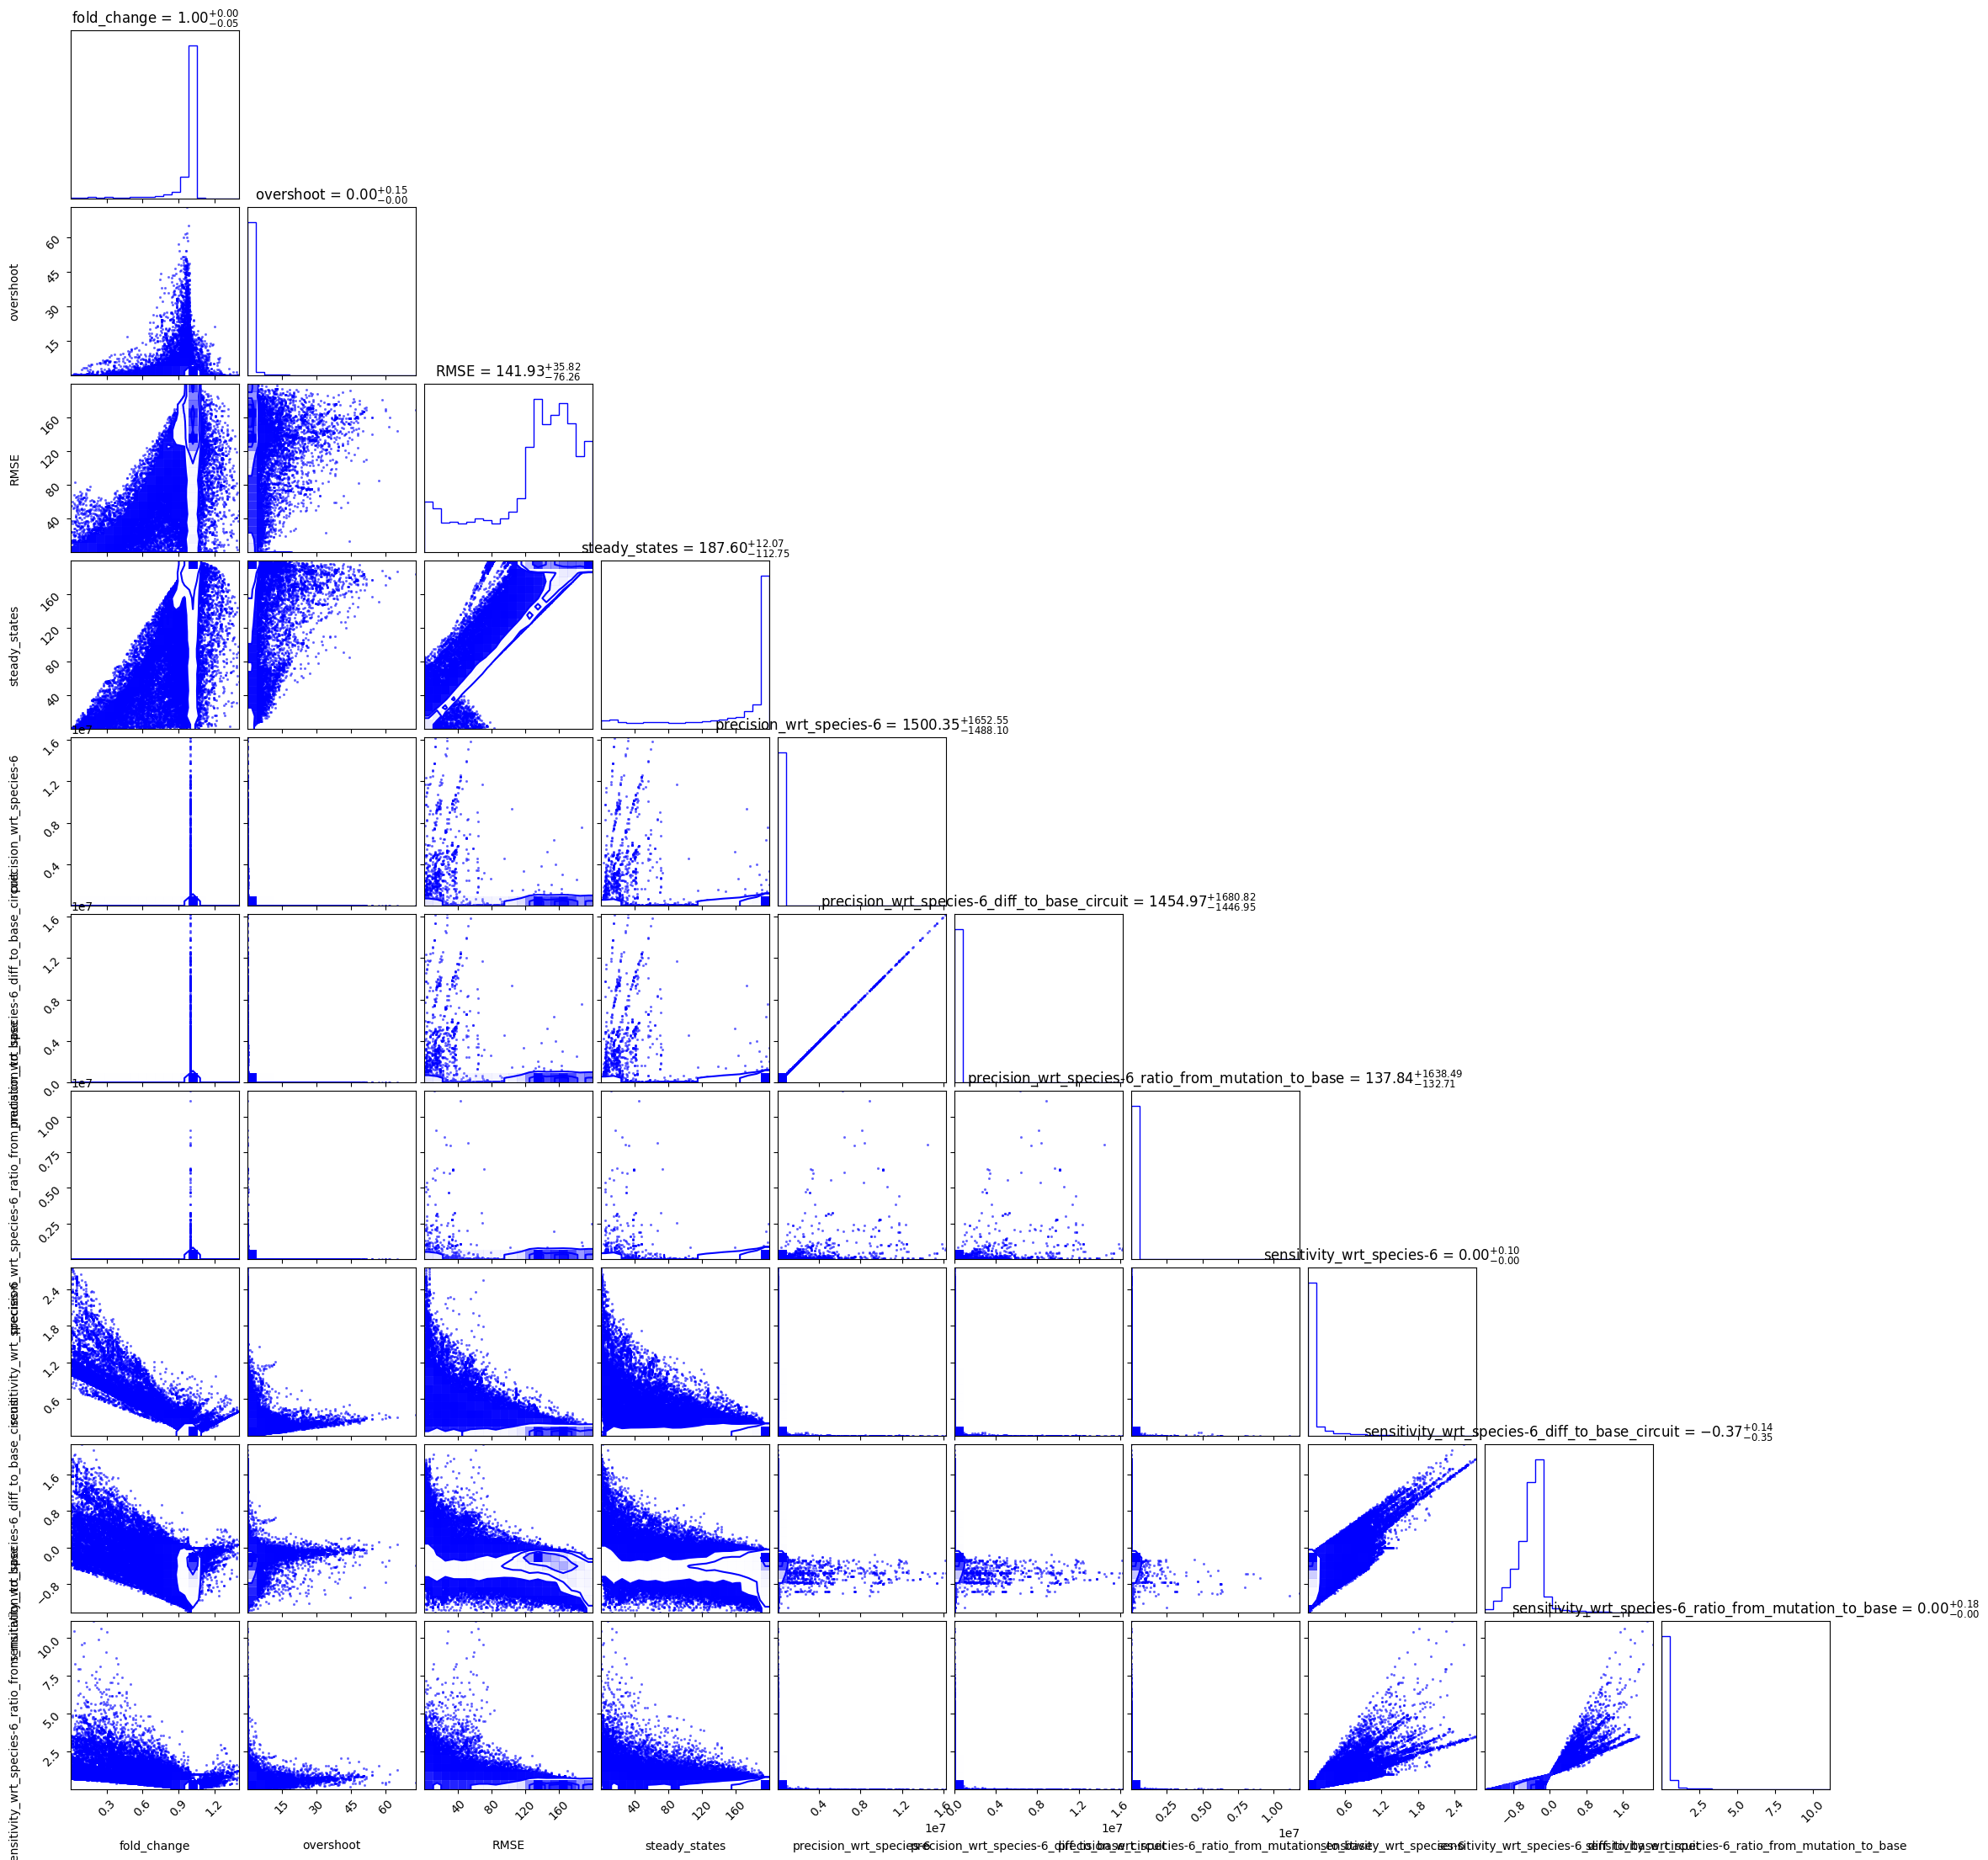

In [7]:

cols = relevant_cols[0:10]
temp = infom[(infom['sample_name'] != 'RNA_0') & (infom['precision_wrt_species-6'] != np.inf) & (infom['precision_wrt_species-6_diff_to_base_circuit'] != -np.inf)][cols]
# for c in cols:
#     if 'precision' in c:
#         temp[c] = np.log(temp[c])
fig = corner.corner(temp, labels=cols, show_titles=True, title_kwargs={"fontsize": 12}, color='b')
fig.savefig('test.png')


Closer look at raw columns

In [8]:

# # %%
# sns.jointplot(infom, x='fold_change', y='RMSE', hue='mutation_num')
# plt.xscale('log')
# plt.yscale('log')

# # %%
# sns.jointplot(infom[infom['sample_name'] != 'RNA_0'], x='fold_change', y='RMSE', hue='mutation_num')
# # plt.xscale('log')
# # plt.yscale('log')

# # %%
# # sns.jointplot(infom, x='fold_change', y='precision_wrt_species-6', hue='sensitivity_wrt_species-6')
# # plt.xscale('log')
# # plt.yscale('log')

# # %%
# sns.jointplot(infom, x='eqconstants', y='RMSE', hue='mutation_num')

# # %%
# sns.jointplot(infom, x='sensitivity_wrt_species-6_diff_to_base_circuit', y='precision_wrt_species-6_diff_to_base_circuit', hue='mutation_num')
# plt.xscale('log')
# plt.yscale('log')

# # %%
# sns.jointplot(infom, x='sensitivity_wrt_species-6_ratio_from_mutation_to_base', y='precision_wrt_species-6_ratio_from_mutation_to_base', hue='mutation_num')
# plt.xscale('log')
# plt.yscale('log')

# # %%
# sns.jointplot(info, x='RMSE', y='overshoot', hue='mutation_num')
# # plt.yscale('log')

# # %%
# sns.jointplot(info, x='fold_change', y='sensitivity_wrt_species-6_diff_to_base_circuit', hue='mutation_num')
# # sns.kdeplot(infom, x='fold_change', y='sensitivity_wrt_species-6_diff_to_base_circuit') #, fill=True, cbar=True) #, hue='mutation_num')
# # plt.yscale('log')

# # %%
# sns.jointplot(info, x='steady_states', y='RMSE', hue='mutation_num')

Sensitivity vs. Precision: Raw

In [9]:


# # %%
# sns.jointplot(infom, x='sensitivity_wrt_species-6', y='precision_wrt_species-6', hue='energies')
# plt.xscale('log')
# plt.yscale('log')

# # %%
# sns.jointplot(infom, x='sensitivity_wrt_species-6', y='precision_wrt_species-6', hue='mutation_num')
# plt.xscale('log')
# plt.yscale('log')

# plt.plot(np.ones(100), np.linspace(10, 1e7, 100), color='r')
# plt.plot(np.linspace(1, 10, 40), np.ones(40) * 10, color='r')

# # %%
# sns.jointplot(infom, x='sensitivity_wrt_species-6', y='precision_wrt_species-6', hue='num_groups')
# plt.xscale('log')
# plt.yscale('log')

# plt.plot(np.ones(100), np.linspace(10, 1e7, 100), color='r')
# plt.plot(np.linspace(1, 10, 40), np.ones(40) * 10, color='r')

# # %%
# sns.jointplot(infom[infom['sample_name'] != 'RNA_0'], x='sensitivity_wrt_species-6', y='precision_wrt_species-6', hue='mutation_num')
# plt.xscale('log')
# plt.yscale('log')

# plt.plot(np.ones(100), np.linspace(10, 1e7, 100), color='r')
# plt.plot(np.linspace(1, 10, 40), np.ones(40) * 10, color='r')

# # %%
# sns.jointplot(infom, x='sensitivity_wrt_species-6', y='precision_wrt_species-6', hue='sample_name')
# plt.xscale('log')
# plt.yscale('log')

# plt.plot(np.ones(100), np.linspace(10, 1e7, 100), color='r')
# plt.plot(np.linspace(1, 10, 40), np.ones(40) * 10, color='r')



## Standard deviations


In [10]:
named_aggs = {}
for c in relevant_cols:
    named_aggs.update({c + '_std': pd.NamedAgg(column=c, aggfunc="std")})
    named_aggs.update({c + '_mean': pd.NamedAgg(column=c, aggfunc="mean")})
    named_aggs.update({c + '_std_normed_by_mean': pd.NamedAgg(column=c, aggfunc=lambda x: np.std(x) / np.max([1, np.mean(x)]))})
info_summ = infom.groupby(['circuit_name', 'mutation_num', 'sample_name'], as_index=False).agg(**named_aggs)
    # {c: [np.std, np.mean, lambda x: np.std(x) / np.mean(x)] for c in relevant_cols})

In [11]:

# %%
stds = info_summ.groupby(['mutation_num'], as_index=False).agg({c + '_std': 'std' for c in relevant_cols})
means = info_summ.groupby(['mutation_num'], as_index=False).agg({c + '_mean': 'mean' for c in relevant_cols})
for c in means.columns:
    stds[c] = means[c]


# %%
std_m = stds.melt(id_vars=['mutation_num'], value_vars=[sc for sc in stds.columns if (sc != 'mutation_num') and ('std' in sc)], value_name='analytic_value', var_name='analytic').rename(columns={'mutation_num': 'mutation_num'})
std_m2 = std_m.groupby(['analytic']).apply(lambda x: x / x.max())
std_m2['analytic'] = std_m['analytic']

/tmp/ipykernel_2500774/3848320783.py:10: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  std_m2 = std_m.groupby(['analytic']).apply(lambda x: x / x.max())


### Visualise STDs

<AxesSubplot: xlabel='precision_wrt_species-6_std', ylabel='Count'>

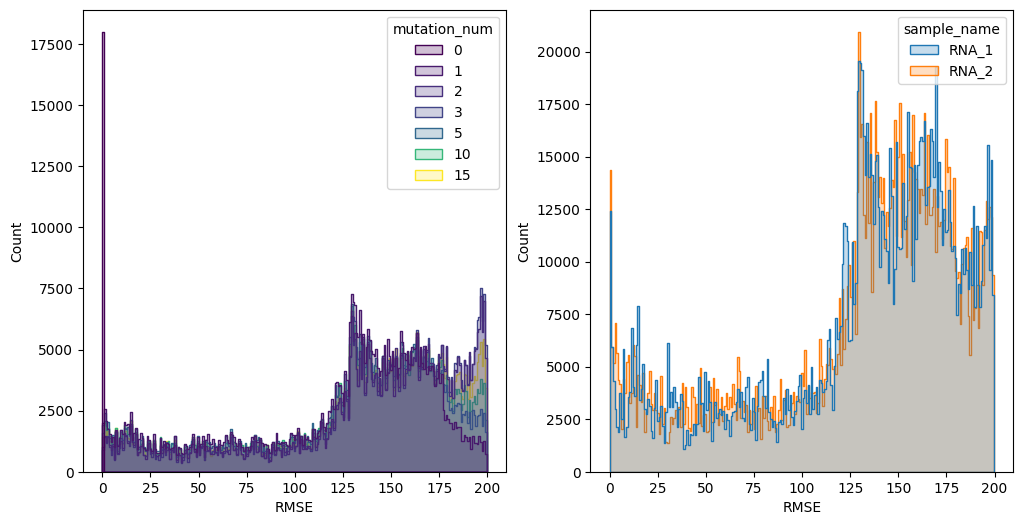

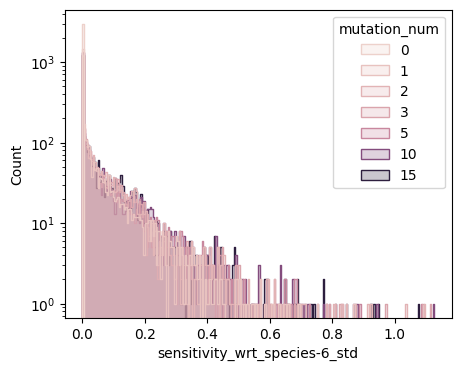

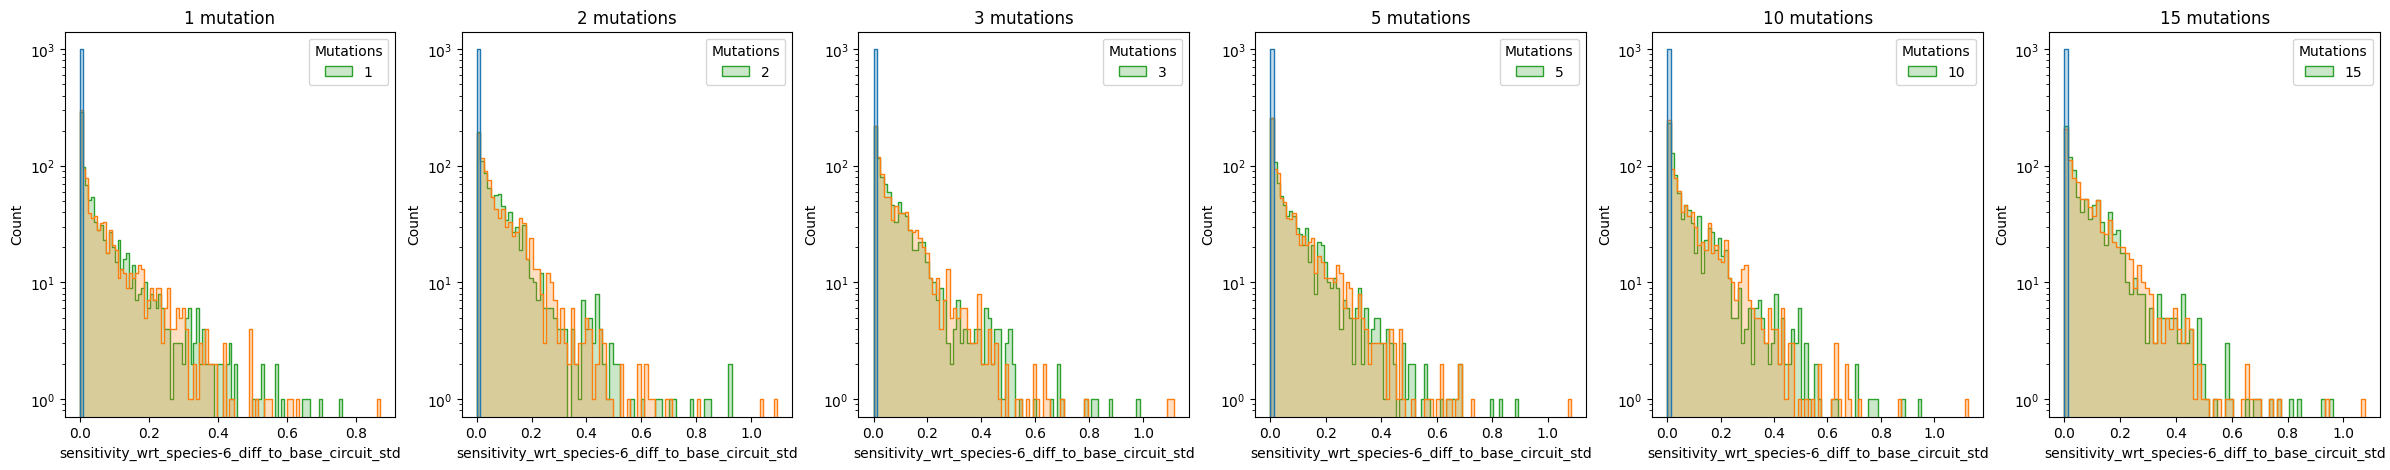

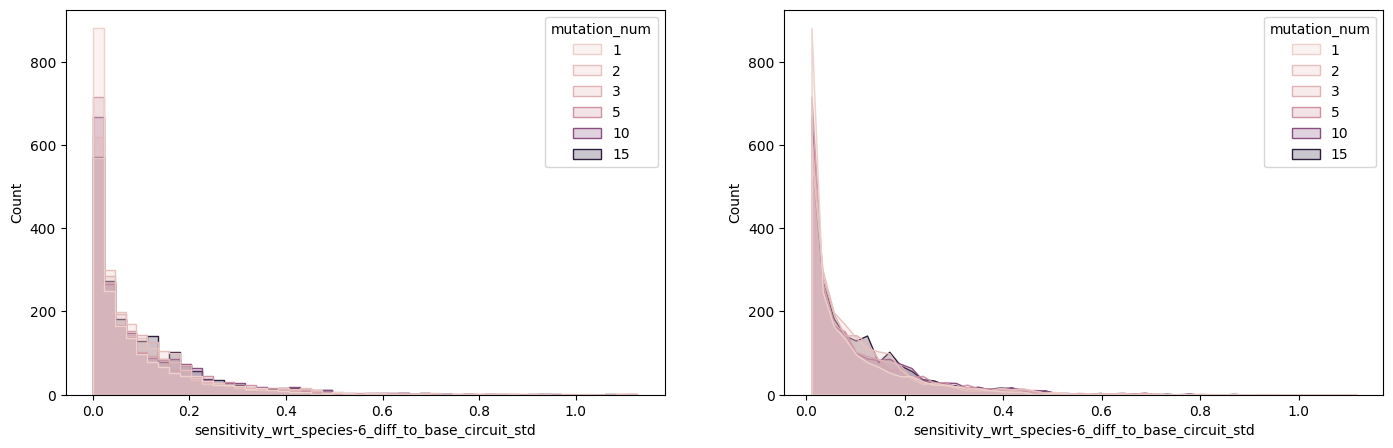

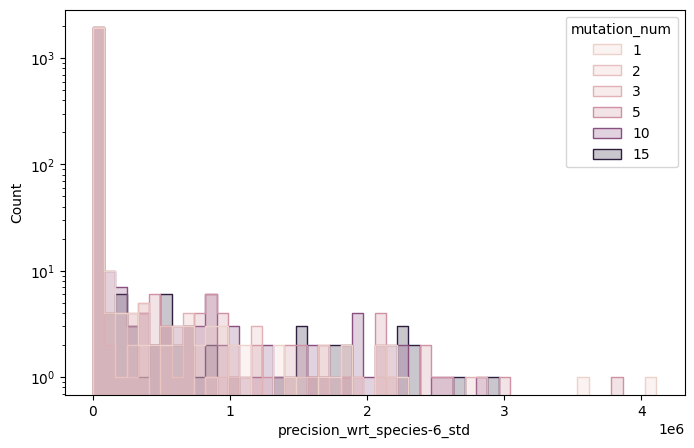

In [12]:


# %%
plt.figure(figsize=(12,6))
ax = plt.subplot(1,2,1)
sns.histplot(data=infom[infom['sample_name'] != 'RNA_0'], x='RMSE', hue='mutation_num', element='step', palette='viridis')
ax = plt.subplot(1,2,2)
sns.histplot(infom[infom['sample_name'] != 'RNA_0'], x='RMSE', hue='sample_name', element='step')


# %%
plt.figure(figsize=(5,4))
sns.histplot(info_summ, x='sensitivity_wrt_species-6' + '_std', element='step', hue='mutation_num', log_scale=[False, True])


# %%
plt.figure(figsize=(5*len(info_summ['mutation_num'].unique()), 5))
for i, m in enumerate(info_summ['mutation_num'].unique()):
    if m != 0:
        ax = plt.subplot(1, len(info_summ['mutation_num'].unique()), i)
        sns.histplot(info_summ[info_summ['mutation_num'] == m], x='sensitivity_wrt_species-6_diff_to_base_circuit' + '_std', element='step', hue='sample_name', log_scale=[False, True])
        plt.legend([str(m)], title='Mutations')
        plt.title(f'{str(m)} mutations' if m != 1 else '1 mutation')
        # plt.xlim([info_summ['sensitivity_wrt_species-6_diff_to_base_circuit' + '_std'].min() - 0.01, info_summ['sensitivity_wrt_species-6_diff_to_base_circuit' + '_std'].max() + 0.01])
        # plt.ylim([0,165])


# %%
plt.figure(figsize=(17,5))
ax = plt.subplot(1,2,1)
sns.histplot(info_summ[(info_summ['sensitivity_wrt_species-6_diff_to_base_circuit' + '_std'] > 0) & (info_summ['sample_name'] != 'RNA_0')], x='sensitivity_wrt_species-6_diff_to_base_circuit' + '_std', hue='mutation_num', element="step", bins=50)
ax = plt.subplot(1,2,2)
sns.histplot(info_summ[(info_summ['sensitivity_wrt_species-6_diff_to_base_circuit' + '_std'] > 0) & (info_summ['sample_name'] != 'RNA_0')], x='sensitivity_wrt_species-6_diff_to_base_circuit' + '_std', hue='mutation_num', element="poly", bins=50)


plt.figure(figsize=(8,5))
# sns.histplot(info_summ[(info_summ['mutation_num'] != 0) & (info_summ['sample_name'] != 'RNA_0')], x='precision_wrt_species-6_diff_to_base_circuit' + '_std', hue='mutation_num', element="step", bins=50, log_scale=[True, False])
sns.histplot(info_summ[(info_summ['mutation_num'] != 0) & (info_summ['sample_name'] != 'RNA_0')], x='precision_wrt_species-6' + '_std', hue='mutation_num', element="step", bins=50, log_scale=[False, True])

Grouped

<AxesSubplot: xlabel='mutation_num', ylabel='fold_change_std_normed_by_mean'>

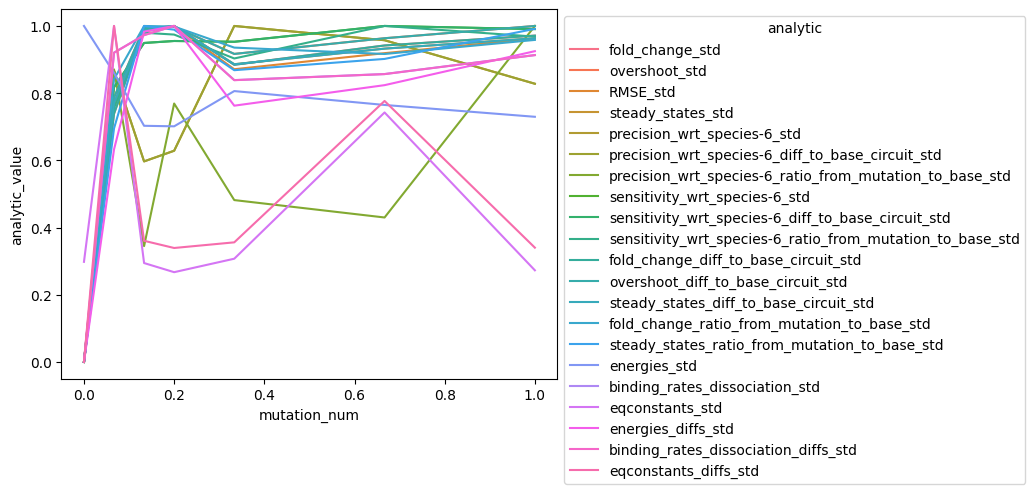

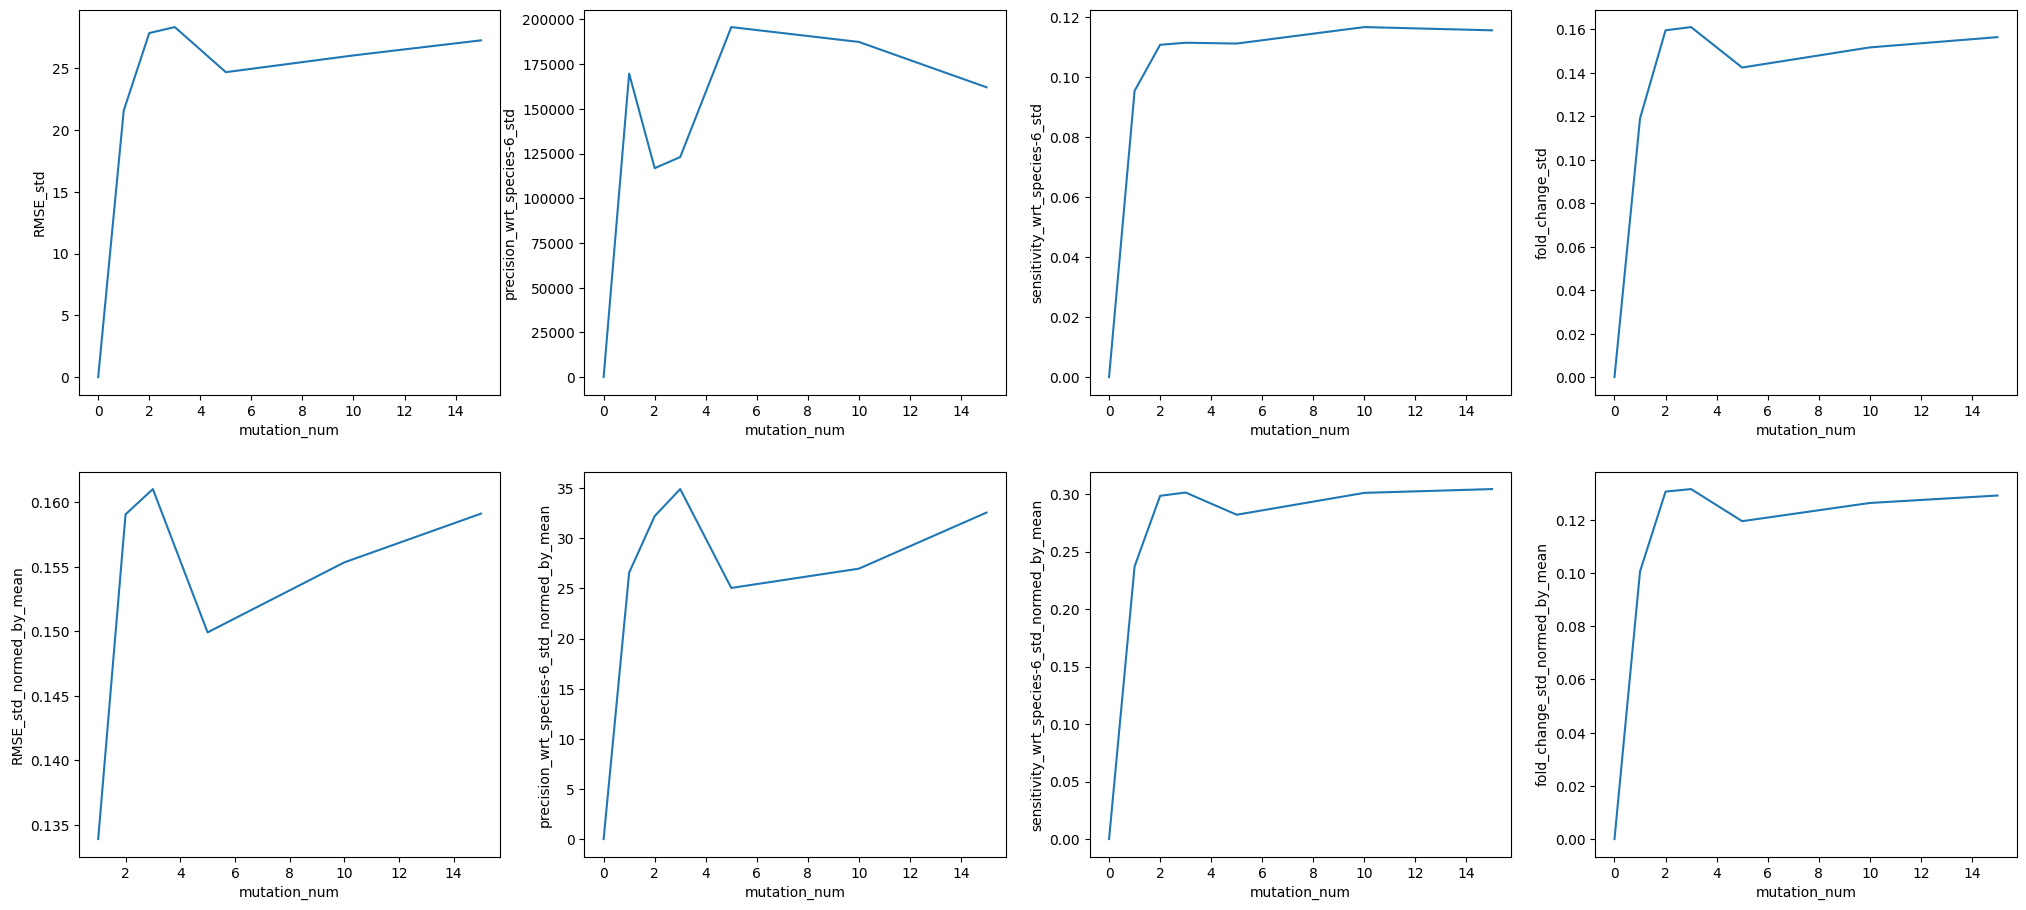

In [13]:

# %%
ax = sns.lineplot(std_m2, 
             x='mutation_num', y='analytic_value', hue='analytic')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# %%
std_cols = ['RMSE',
            'precision_wrt_species-6',
            'sensitivity_wrt_species-6',
            'fold_change']
for sc in std_cols:
    stds[sc + '_std_normed_by_mean'] = stds[sc + '_std'] / stds[sc + '_mean']

plt.figure(figsize=(25, 11))
ax = plt.subplot(2, 4, 1)
sns.lineplot(stds, x='mutation_num', y='RMSE' + '_std')
ax = plt.subplot(2, 4, 2)
sns.lineplot(stds, x='mutation_num', y=
    'precision_wrt_species-6' + '_std')
ax = plt.subplot(2, 4, 3)
sns.lineplot(stds, x='mutation_num', y=
    'sensitivity_wrt_species-6' + '_std')
ax = plt.subplot(2, 4, 4)
sns.lineplot(stds, x='mutation_num', y='fold_change' + '_std')

ax = plt.subplot(2, 4, 5)
sns.lineplot(stds, x='mutation_num', y='RMSE' + '_std_normed_by_mean')
ax = plt.subplot(2, 4, 6)
sns.lineplot(stds, x='mutation_num', y=
    'precision_wrt_species-6' + '_std_normed_by_mean')
ax = plt.subplot(2, 4, 7)
sns.lineplot(stds, x='mutation_num', y=
    'sensitivity_wrt_species-6' + '_std_normed_by_mean')
ax = plt.subplot(2, 4, 8)
sns.lineplot(stds, x='mutation_num', y='fold_change' + '_std_normed_by_mean')

# %%
# plt.figure(figsize=(8,5))
# sns.jointplot(info_summ[info_summ['sample_name'] != 'RNA_0'], x='RMSE' + '_std', y='precision_times_sensitivity' + '_mean', hue='mutation_num')

In [14]:
info_summ['robust'] = (info_summ['sensitivity_wrt_species-6' + '_mean'] > 0.9) & (info_summ['precision_wrt_species-6' + '_mean'] > 5)
fig = px.scatter_3d(
    info_summ[info_summ['mutation_num'] != 0],
    x='sensitivity_wrt_species-6' + '_mean', y='precision_wrt_species-6' + '_mean', z='RMSE' + '_std', 
    color='mutation_num', symbol='robust', log_y=True, log_x=True)
fig.show()


## Examine correlations

In [15]:

v = infom[infom['sample_name'] != 'RNA_0'].corr()['mutation_num'].sort_values()
v.to_csv('corrs.csv')


/tmp/ipykernel_2500774/1904057261.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



## Diffs

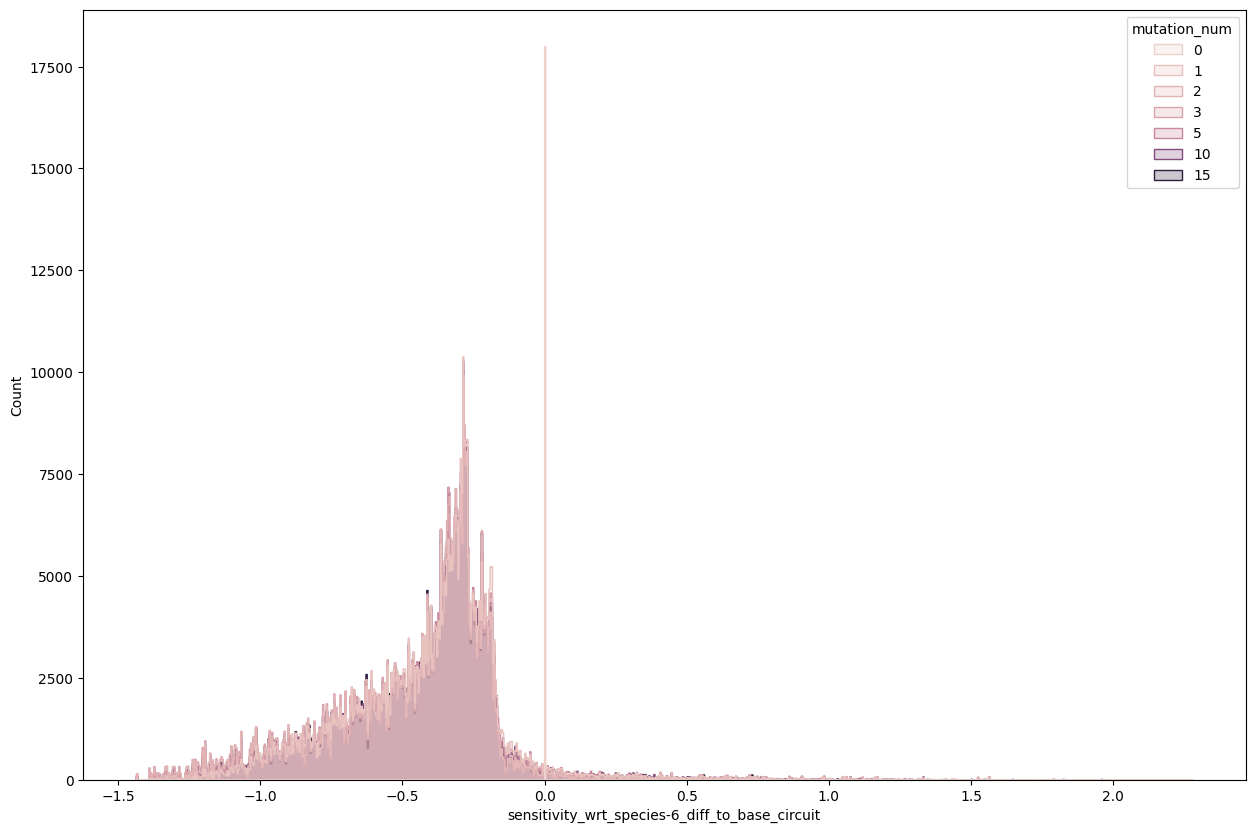

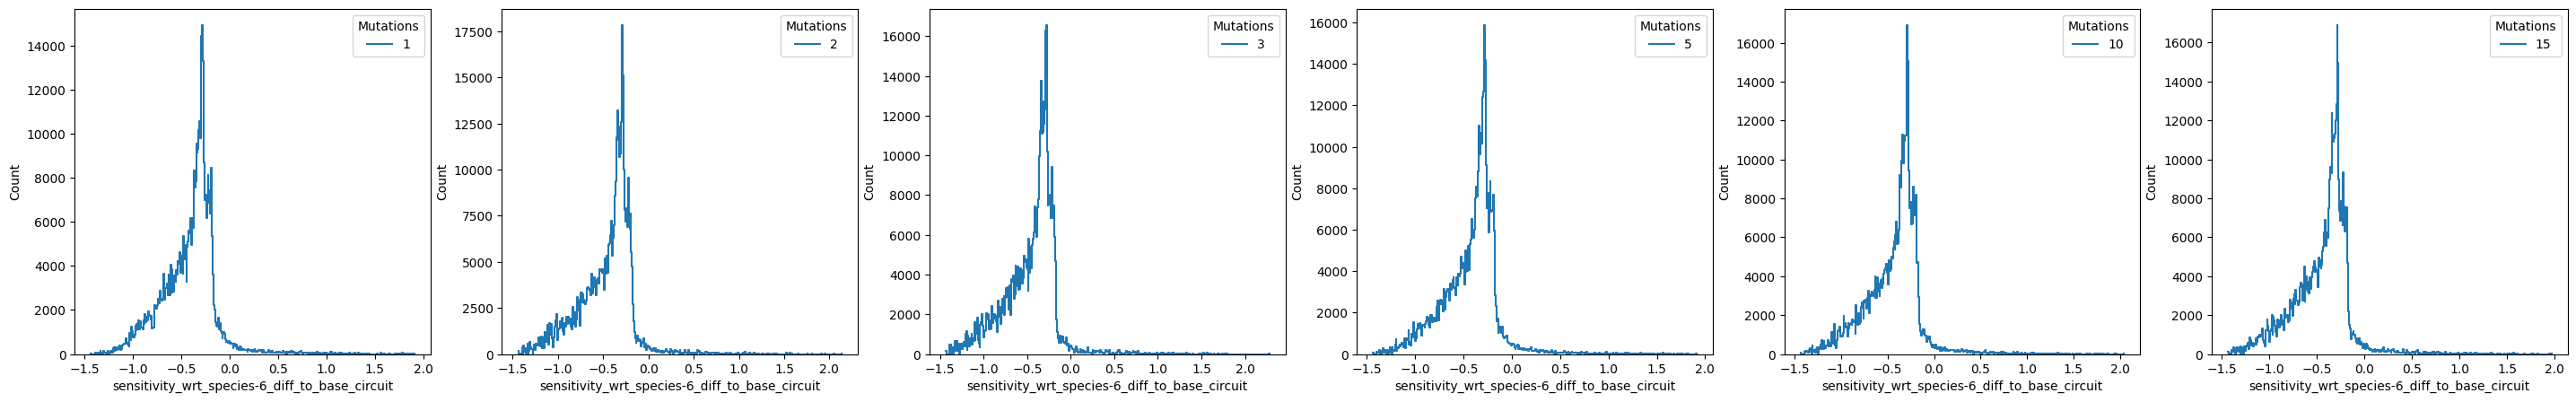

In [16]:

plt.figure(figsize=(15,10))
sns.histplot(infom[infom['sample_name'] != 'RNA_0'], x='sensitivity_wrt_species-6_diff_to_base_circuit', hue='mutation_num', element='step')


# %%
plt.figure(figsize=(6*len(info_summ['mutation_num'].unique()), 5))
for i, m in enumerate(info_summ['mutation_num'].unique()):
    if m != 0:
        ax = plt.subplot(1, len(info_summ['mutation_num'].unique()), i)
        sns.histplot(infom[(infom['sample_name'] != 'RNA_0') & (infom['mutation_num'] == m)], x='sensitivity_wrt_species-6_diff_to_base_circuit', stat='count', element='step', fill=False)
        plt.legend([str(m)], title='Mutations')
        # plt.xlim([info_summ[('sensitivity_wrt_species-6_diff_to_base_circuit', 'std')].min() - 0.01, info_summ[('sensitivity_wrt_species-6_diff_to_base_circuit', 'std')].max() + 0.01])
        # plt.ylim([0,165])


## Energies

/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning:

divide by zero encountered in log10



ValueError: autodetected range of [-inf, 0.2685496308816563] is not finite

/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



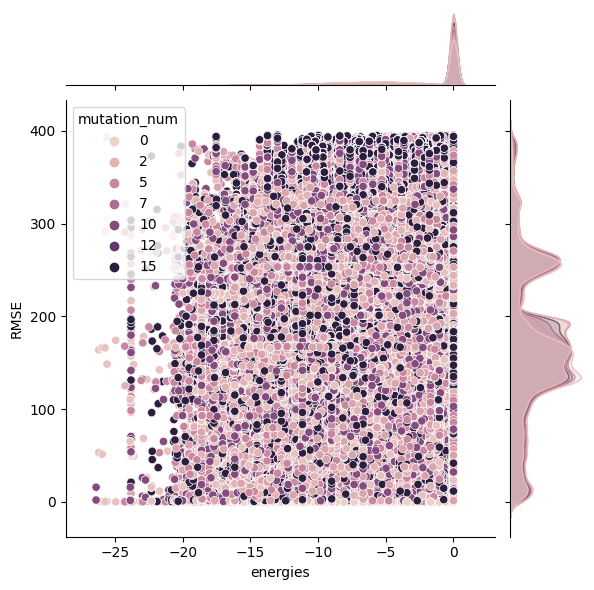

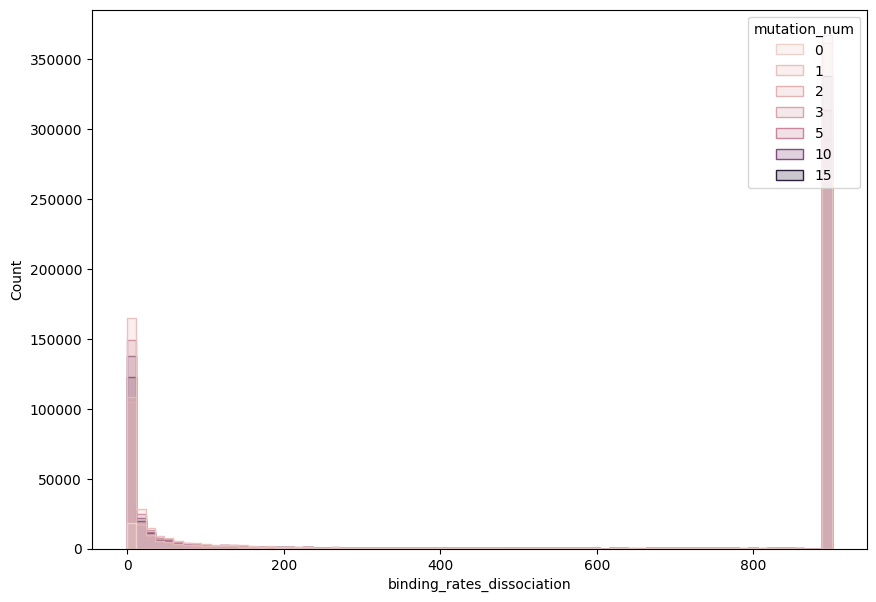

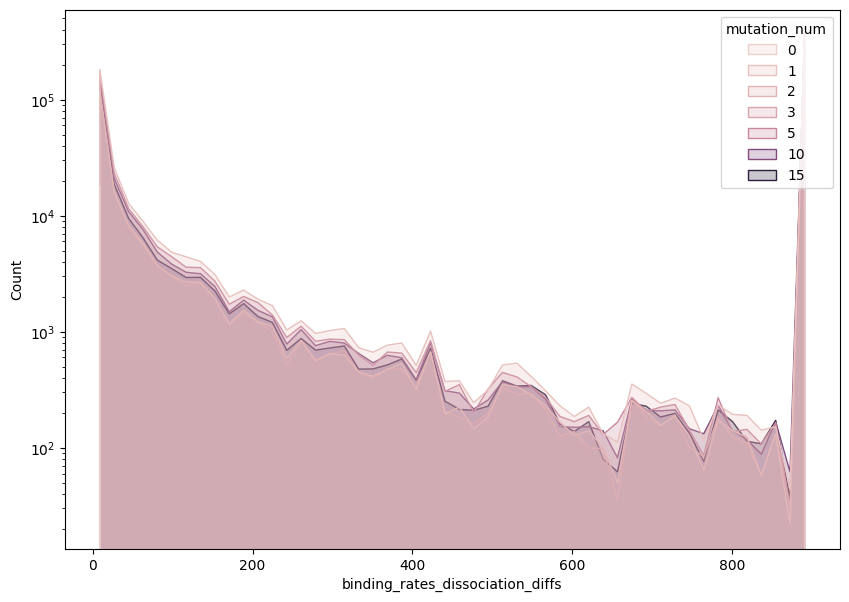

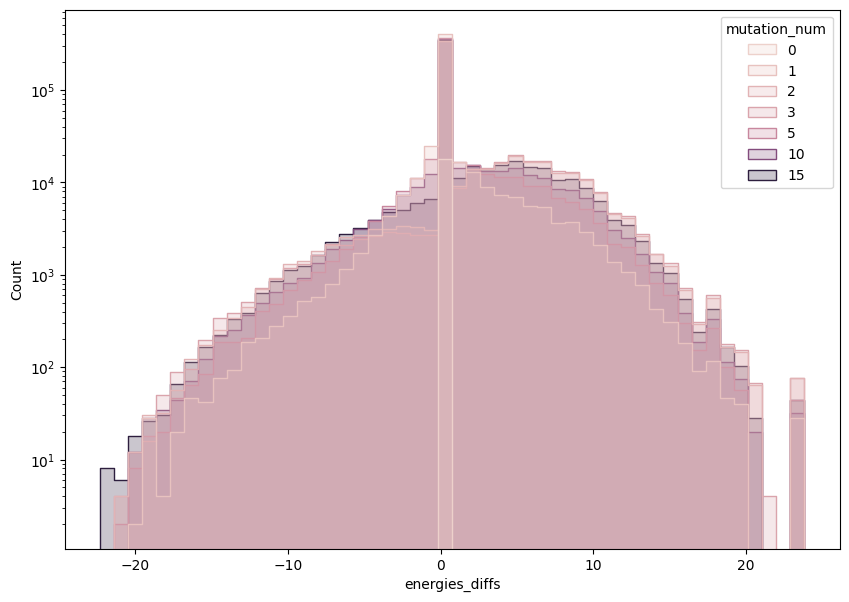

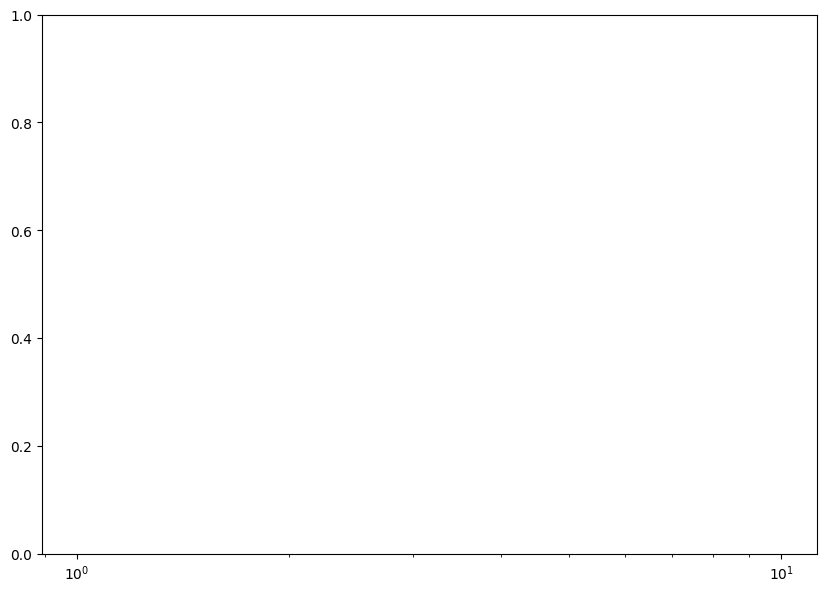

In [17]:
# %%
sns.jointplot(infom, x='energies', y='RMSE', hue='mutation_num')

# %%
plt.figure(figsize=(10,7))
sns.histplot(infom[infom['sample_name'] != 'RNA_0'], x='binding_rates_dissociation', hue='mutation_num', element='step')


# %%
plt.figure(figsize=(10,7))
sns.histplot(infom[infom['sample_name'] != 'RNA_0'], x='binding_rates_dissociation_diffs', hue='mutation_num', element='poly', bins=50, log_scale=[False, True])


# %%
plt.figure(figsize=(10,7))
sns.histplot(infom[infom['sample_name'] != 'RNA_0'], x='energies_diffs', hue='mutation_num', element='step', bins=50, log_scale=[False, True])

# %%
plt.figure(figsize=(10,7))
sns.histplot(info_summ[info_summ['binding_rates_dissociation_diffs' + '_std_normed_by_mean'] < 1e3], x='binding_rates_dissociation_diffs' + '_std_normed_by_mean', hue='mutation_num', element='step', bins=50, log_scale=[True, False])
plt.title('Difference in $k_d$ between mutated and\nreference circuits, cut of at $10^3$')

# %%
plt.figure(figsize=(10,7))
sns.histplot(info_summ[info_summ['binding_rates_dissociation_diffs' + '_std_normed_by_mean'] < 1e3], x='binding_rates_dissociation_diffs' + '_std_normed_by_mean', hue='mutation_num', element='poly', bins=50, log_scale=[True, False])
plt.title('Difference in $k_d$ between mutated and\nreference circuits, cut of at $10^3$')

# %%
plt.figure(figsize=(10,7))
sns.histplot(info_summ, x='energies_diffs' + '_std_normed_by_mean', hue='mutation_num', element='poly', bins=50, log_scale=[True, False])
plt.title('Difference in $k_d$ between mutated and reference circuits')

# %%
plt.figure(figsize=(10,7))
sns.histplot(infom[infom['eqconstants'] > 0.009], x='eqconstants', hue = 'mutation_num', multiple='layer', element='step', stat='count', log_scale=[True, False], bins=50)
# plt.xscale('log')

# %%
plt.figure(figsize=(10,7))
sns.jointplot(infom, x='mutation_num', y = 'num_groups')

In [ ]:

plt.figure(figsize=(6*len(info_summ['mutation_num'].unique()), 5))
for i, m in enumerate(info_summ['mutation_num'].unique()):
    if m != 0:
        ax = plt.subplot(1, len(info_summ['mutation_num'].unique()), i)
        sns.histplot(infom[(infom['eqconstants'] >= 1) & (infom['mutation_num'] == m)], x='eqconstants', stat='count', element='step', fill=True)
        plt.legend(str(m), title='Mutations')
        plt.xlim([-3, 103])
        plt.ylim([0,6000])


In [ ]:

plt.figure(figsize=(10,7))
sns.histplot(infom, x='energies', hue='mutation_num', element='step')
